In this notebook we're going to explore the use of an LLM for supervised (classification) and unsuprvised (clustering) ML tasks using time-series data. The following cell does our imports and loads some data into the workspace. The training set consists of three families (or classes) of 32-point curves, with 5 examples of each. The test set consists of the same three classes, with two curves each. Note that there isn't really a hard distinction between train and test concepts here, as the LLM hasn't seen either set.

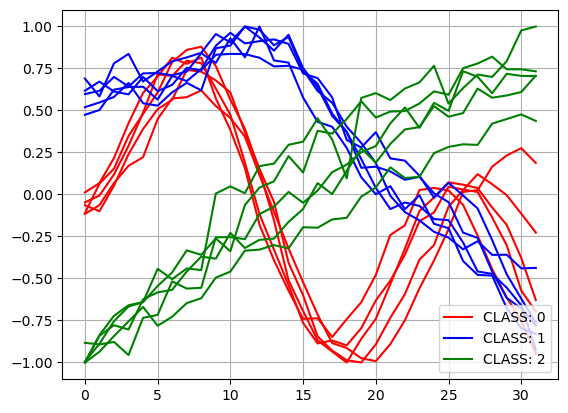

In [1]:
import os
import sys
import random
import json
import pprint
from google import genai
from google.genai import types

sys.path.append(os.getcwd())

import llm_utils
from llm_utils import supervised_prompt, unsupervised_prompt, plot_group

api_key = os.environ.get('genai_key')
client = genai.Client(api_key=api_key)

train, test = llm_utils.get_data()
plot_group(llm_utils.group(train)) # plot for visualization

The first task will be a supervised learning task. We'll give the model the set of curves and their class labels and ask it to classify several unseen examples. This is also an example of in-context learning. First, lets build the prompt and print it.

In [14]:
ICL = supervised_prompt(train) #In-context learning  - this will be fed into the system instruction

# We'll build a prompt asking for two unseen examples from the test set
examples = random.sample(test, 2)

# this will be passed in as the user prompt
prompt = """
Do not repeat the sequence. Only print the class.

SEQUENCE: {}
CLASS: 
SEQUNECE: {}
CLASS:
""".format(*[llm_utils.seq_enc(x[0]) for x in examples])

print (ICL)
print (prompt)



SEQUENCE: -1.00,-0.94,-0.84,-0.76,-0.67,-0.78,-0.73,-0.65,-0.62,-0.50,-0.46,-0.33,-0.33,-0.30,-0.32,-0.19,-0.20,-0.15,-0.14,-0.01,0.04,0.16,0.10,0.11,0.25,0.28,0.30,0.30,0.42,0.45,0.48,0.44
CLASS: 2
SEQUENCE: -0.11,0.06,0.15,0.35,0.48,0.61,0.79,0.86,0.88,0.76,0.56,0.39,0.14,-0.15,-0.51,-0.69,-0.87,-0.93,-1.00,-0.86,-0.74,-0.53,-0.32,-0.10,-0.02,0.07,0.06,0.04,-0.08,-0.18,-0.38,-0.63
CLASS: 0
SEQUENCE: 0.62,0.67,0.61,0.60,0.70,0.62,0.65,0.75,0.74,0.83,0.84,0.84,0.81,0.76,0.77,0.74,0.62,0.55,0.40,0.31,0.19,-0.01,-0.10,-0.15,-0.22,-0.26,-0.33,-0.28,-0.36,-0.36,-0.44,-0.44
CLASS: 1
SEQUENCE: -0.06,-0.10,0.05,0.24,0.39,0.51,0.56,0.74,0.73,0.68,0.61,0.37,0.15,-0.04,-0.41,-0.60,-0.85,-0.93,-0.99,-1.00,-0.89,-0.73,-0.59,-0.39,-0.30,-0.07,0.03,0.12,0.06,-0.00,-0.11,-0.23
CLASS: 0
SEQUENCE: -0.88,-0.89,-0.88,-0.96,-0.73,-0.72,-0.52,-0.56,-0.56,-0.26,-0.25,-0.27,-0.12,-0.07,0.02,-0.05,0.02,0.13,0.18,0.25,0.29,0.42,0.52,0.40,0.55,0.50,0.73,0.70,0.60,0.72,0.71,0.71
CLASS: 2
SEQUENCE: 0.60,0.62,0.70

The first part (the in-context learning portion) contains our training data - 15 sequences and their class labels, in random order. The user prompt then lists two "unseen" sequenes with empty CLASS placeholders. Notice we've provided very little instruction here! Next, we'll feed this into the model and check the response.

In [16]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=ICL,
        temperature=0.2),
    contents=prompt
    )
    
print(f'Input class: {[x[1] for x in examples]}\nReported class: [{", ".join(response.text.splitlines())}]')


Input class: [0, 2]
Reported class: [0, 2]


Cool! We gave it examples from classes 0 and 2, and it correctly classified them. While this may not look that exciting, it's pretty neat that it can do the work of a classifier with just some prompting.

(In this example the training data was fed into the system instruction, and the request was fed in as the user prompt but the entire thing could have been concatenated to a single user prompt as well)

Next up we'll try an unsupervised task. We'll give it the set of shuffled training sequences without labels and ask it to perform clustering. In our prompt, we'll include a request to respond with JSON.

In [36]:
initial = """Assign each of the following sequences to 1 of 3 clusters. 

Use the following JSON schema in your response: 
{'cluster': int, 'sequences': list[int], 'explanation': str}

"""

prompt = unsupervised_prompt(train, initial)


response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(temperature=0.4,
    response_mime_type="application/json"),        
    contents=prompt
    )
json_dict = json.loads(response.text)

Lets take a look at the prompt (in this case just a single user prompt) and the response.

In [38]:
print("***** PROMPT:\n"+prompt)
print("***** RESPONSE:\n"+response.text)

***** PROMPT:
Assign each of the following sequences to 1 of 3 clusters. 

Use the following JSON schema in your response: 
{'cluster': int, 'sequences': list[int], 'explanation': str}

0: -1.00,-0.94,-0.84,-0.76,-0.67,-0.78,-0.73,-0.65,-0.62,-0.50,-0.46,-0.33,-0.33,-0.30,-0.32,-0.19,-0.20,-0.15,-0.14,-0.01,0.04,0.16,0.10,0.11,0.25,0.28,0.30,0.30,0.42,0.45,0.48,0.44
1: -0.11,0.06,0.15,0.35,0.48,0.61,0.79,0.86,0.88,0.76,0.56,0.39,0.14,-0.15,-0.51,-0.69,-0.87,-0.93,-1.00,-0.86,-0.74,-0.53,-0.32,-0.10,-0.02,0.07,0.06,0.04,-0.08,-0.18,-0.38,-0.63
2: 0.62,0.67,0.61,0.60,0.70,0.62,0.65,0.75,0.74,0.83,0.84,0.84,0.81,0.76,0.77,0.74,0.62,0.55,0.40,0.31,0.19,-0.01,-0.10,-0.15,-0.22,-0.26,-0.33,-0.28,-0.36,-0.36,-0.44,-0.44
3: -0.06,-0.10,0.05,0.24,0.39,0.51,0.56,0.74,0.73,0.68,0.61,0.37,0.15,-0.04,-0.41,-0.60,-0.85,-0.93,-0.99,-1.00,-0.89,-0.73,-0.59,-0.39,-0.30,-0.07,0.03,0.12,0.06,-0.00,-0.11,-0.23
4: -0.88,-0.89,-0.88,-0.96,-0.73,-0.72,-0.52,-0.56,-0.56,-0.26,-0.25,-0.27,-0.12,-0.07,0.02,-0.0

Cool! We got back a nice JSON response with 3 clusters identified, the sequences selected, and an explanation for each. Lets see how well it did...


CLASS 0:
These sequences start with negative values and gradually increase to positive values, with some fluctuations.

CLASS 1:
These sequences start near zero, move to positive values, then decrease to negative values, and return to near zero.

CLASS 2:
These sequences start with positive values and generally decrease over time, with some fluctuations.


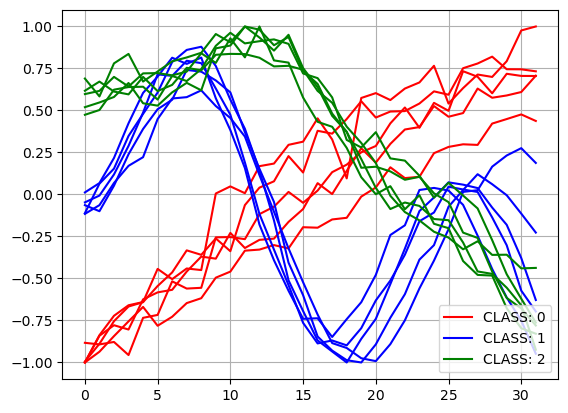

In [40]:
from colorama import Fore

# Convert the json dict into a grouped dict for plotting, and print the 
# explanations in colors.
ai_grouped = {}
clrs = [Fore.RED, Fore.BLUE, Fore.GREEN]
for entry in json_dict:    
    this_class = entry['cluster']
    sequences = entry['sequences']
    ai_grouped[this_class] = [ train[x][0] for x in sequences]    
    print(clrs[this_class] + f'\nCLASS {this_class}:\n' + entry['explanation'])

plot_group(ai_grouped)

The plot shows it clustered the curves correctly (see first plot), though with a different label ordering. Take a moment to read the explanations, coloured in accordance with their classes - it's quite interesting that it can identify fairly complex shapes in the data. So there you have it - an LLM performing unsupervised clustering on time-series data!